# PHYS3070: Buoyancy driven flow with thermal diffusion

Romain Beucher and Louis Moresi

This Jupyter notebook introduce Underworld, a research software solving the Stokes and Advection-Diffusion equation with applications to Earth's dynamics. It is part of a series of examples designed to develop your intuition about processes responsible for the flow inside the Earth.

<img src="images/Picture7.png" width="800">


$$\text{Activity} = \frac{\text{Parameters that enhance flow}}{\text{Parameters that retard flow}}$$

The present example illustrates the principle of buoyancy. 

$$\text{Buoyancy} \propto g\rho_0\alpha\left(1-\Delta T \right)$$

A ball is placed inside a container filled with a viscous liquid.
The density of the ball is greater than the density of the surrounding fluid: the ball sinks under the influence of gravity, creating a flow inside the container.
The ball is also initially colder and is slowly heated up by the surrounding hot material.

$$\left( \frac{\partial T}{\partial t} + \left(v \cdot \nabla \right) T \right) = \kappa \nabla^2T$$ 

The student is encouraged to explore how changing the density contrast between the ball and the surrounding fluid affects the displacement of the ball. They can also change the viscosity of the materials.

## Import UWGeodynamics

We will use *UWGeodynamics*, a high-level interface to the Underworld API.
The python module can be imported as follow.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /home/jovyan/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


## Scaling

In [2]:
u = GEO.UnitRegistry

In [4]:
velocity = 1.0 * u.meter / u.hour
model_length = 2. * u.meter
model_height = 1. * u.meter
refViscosity = 1e6 * u.pascal * u.second
bodyforce = 200 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
temperature_diff = 300. * u.degK

characteristic_length = model_height
characteristic_time = characteristic_length / velocity
characteristic_mass = bodyforce * characteristic_length**2 * characteristic_time**2
characteristic_temperature = temperature_diff

GEO.scaling_coefficients["[length]"] = characteristic_length
GEO.scaling_coefficients["[time]"] = characteristic_time
GEO.scaling_coefficients["[mass]"]= characteristic_mass
GEO.scaling_coefficients["[temperature]"] = characteristic_temperature

# Geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)

We define a tank in 2-dimensions. The dimension of the tank is set to be 1m in height and 1m in width. The extent of the tank is defined using the `minCoord` and `maxCoord` arguments chosen in a way that the origin is located at the center of the tank.

In [5]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(-0.5 * u.m, -0.5 * u.m), 
                  maxCoord=(0.5 * u.m, 0.5 * u.m),
                  gravity=(0., -9.81 * u.m / u.s**2))

## Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
*UWGeodynamics* is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

The tank is filled with a viscous fluid (`background_fluid`).

In [6]:
background_fluid = Model.add_material(name="Background", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))

A ball of denser material (`ball`) is placed in the fluid 30 cm above the center of the tank (20cm from the top of the box.). The ball diameter is chosen to be 20cm.

In [7]:
Disk = GEO.shapes.Disk(center=(0.,30.*u.centimetre), radius= 7.5 *  u.centimetre)
ball = Model.add_material(name="Ball", shape=Disk)

### Visualisation of the materials


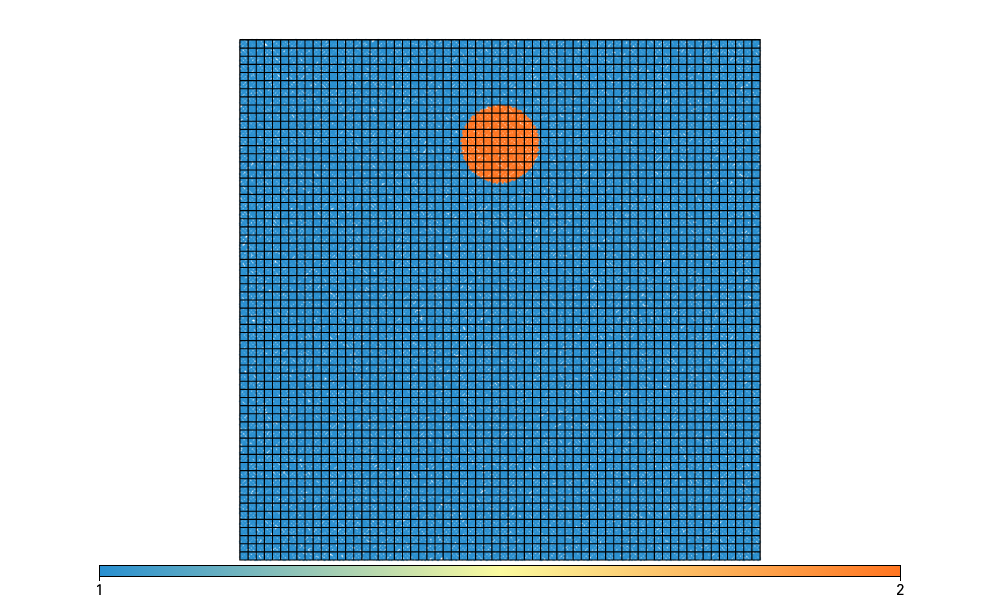

In [8]:
Fig1 = vis.Figure(figsize=(1000,600))
Fig1.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig1.Mesh(Model.mesh)
Fig1.show()

### Material properties

In [9]:
background_fluid.viscosity = 1e6 * u.pascal * u.second
background_fluid.diffusivity = 1e-6 * u.meter**2 / u.second

ball.viscosity = 1e6 * u.pascal * u.second
ball.diffusivity = 1e-6 * u.meter**2 / u.second

#### Temperature dependent densities

We express densities as a function of temperature:

$$\rho = \rho_0\alpha\left(1-\Delta T \right)$$

In [10]:
background_fluid.density = GEO.LinearDensity(reference_density=10. * u.kilogram / u.metre**3, thermalExpansivity=3e-4 / u.kelvin)
ball.density = GEO.LinearDensity(reference_density=500. * u.kilogram / u.metre**3, thermalExpansivity=3e-4 / u.kelvin)

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



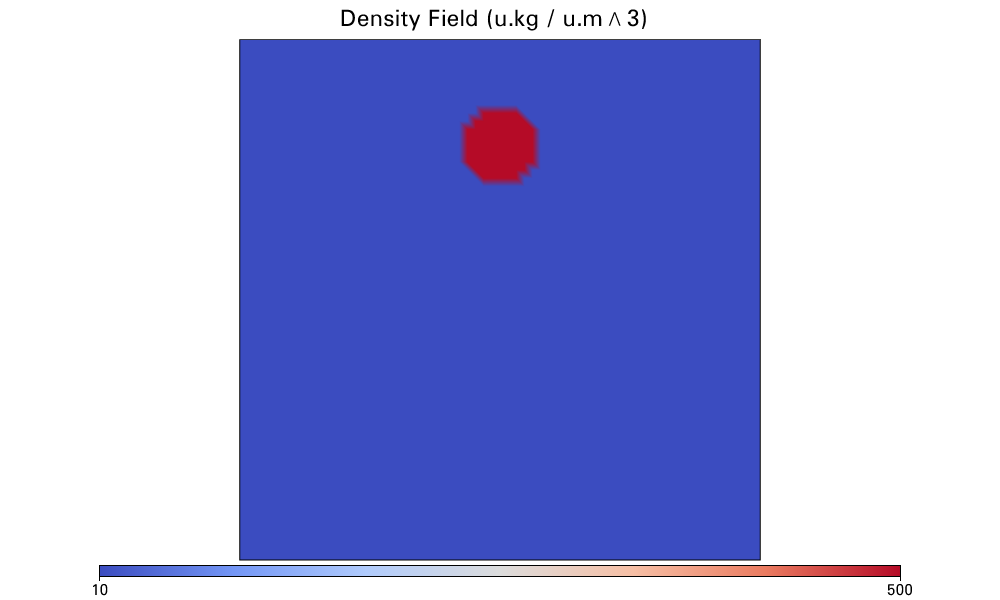

In [11]:
Fig = vis.Figure(figsize=(1000,600), title="Density Field (u.kg / u.m^3)")
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.densityField, u.kg/u.m**3), colours="coolwarm")
Fig.show()

## Define initial temperature of the ball

In [15]:
Model.temperature.data[...] = GEO.nd(373.15 * u.degK)
Model.temperature.data[Disk.evaluate(Model.mesh)] = GEO.nd(273.15 * u.degK)

## Define Boundary Conditions

The boundary conditions are freeslip everywhere (zero shear stress).

In [13]:
Model.set_velocityBCs(left=[0, None], right=[0,None], top=[None, 0.], bottom=[None, 0])

In [14]:
Model.set_temperatureBCs(top=273.15 * u.degK, bottom=573.15 * u.degK)

## Passive Tracers

In [16]:
import numpy as np

angles = np.arange(0., 360)
x = 7.5 * u.cm * np.cos(np.radians(angles)) 
y = 7.5 * u.cm * np.sin(np.radians(angles)) + 30. * u.cm

coords = np.ndarray((360, 2))
coords[:, 0] = x
coords[:, 1] = y

ball_contour = Model.add_passive_tracers(name="ball_contour", vertices=coords)

We can also add a tracer to track the position of the ball through time.

In [17]:
x0, y0 = 0, 0.2

coords = np.array([[x0, y0]])
tipTracker = Model.add_passive_tracers(name="tip", vertices=coords)

## Set up Animation


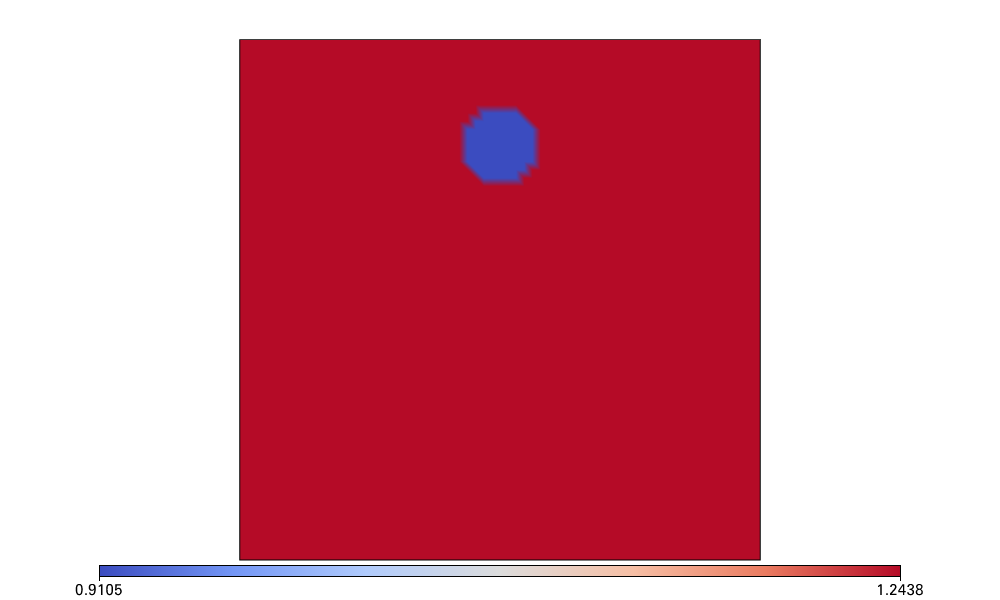

In [18]:
Fig = vis.Figure(figsize=(1000,600))
Fig.Points(ball_contour, size=10.0, colour="k")
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

In [19]:
def update_figure():
    Fig.step = Model.step
    Fig.save()
    
Model.post_solve_functions["figures"] = update_figure

## Init and Run Model

In [20]:
Model.init_model(temperature=False)

In [21]:
Model.run_for(nstep=10, checkpoint_interval=1)

Running with UWGeodynamics version 2.10.0-dev-b0ccd70(new_examples)
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
Step:     1 Model Time: 2.0 minute dt: 2.0 minute (2020-06-23 03:51:21)
Step:     2 Model Time: 4.1 minute dt: 2.0 minute (2020-06-23 03:51:24)
Step:     3 Model Time: 6.1 minute dt: 2.0 minute (2020-06-23 03:51:27)
Step:     4 Model Time: 8.1 minute dt: 2.0 minute (2020-06-23 03:51:30)
Step:     5 Model Time: 10.2 minute dt: 2.0 minute (2020-06-23 03:51:33)
Step:     6 Model Time: 12.2 minute dt: 2.0 minute (2020-06-23 03:51:36)
Step:     7 Model Time: 14.2 minute dt: 2.0 minute (2020-06-23 03:51:39)
Step:     8 Model Time: 16.3 minute dt: 2.0 minute (2020-06-23 03:51:42)
Step:     9 Model Time: 18.3 minute dt: 2.0 minute (2020-0

1


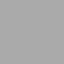

In [22]:
viewer = Fig.viewer()
viewer.control.TimeStepper()
viewer.window()


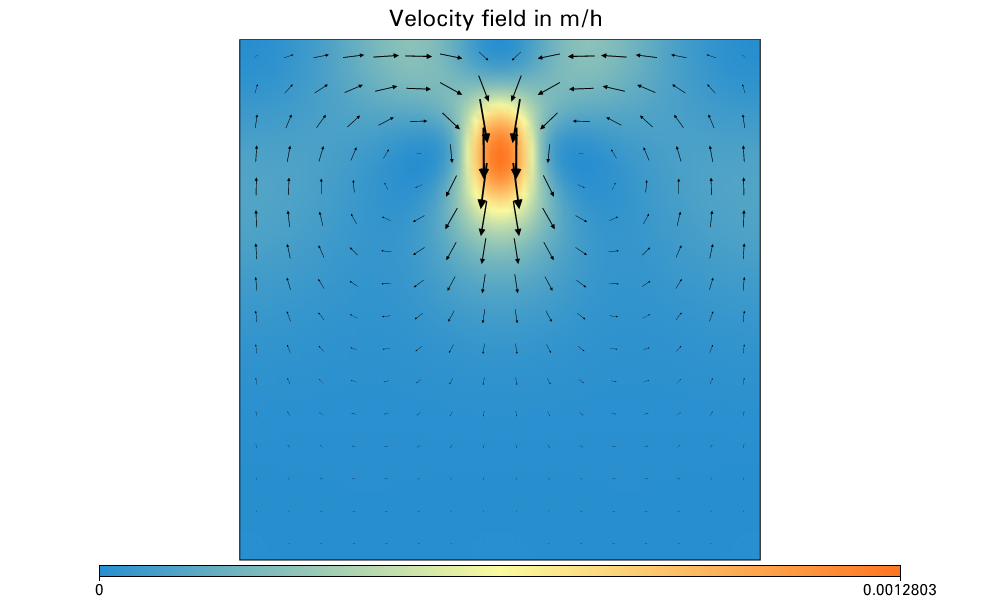

In [23]:
import underworld.function as fn
# Calculate the velocity magnitude
velocityMag = fn.math.dot(Model.velocityField, Model.velocityField)
# Get a conversion factor to units of m/hr
fact = GEO.dimensionalise(1.0, u.metre / u.hour).magnitude
# Apply the factor to the velocity Magnitude
velocityMag *= fact

Fig = vis.Figure(figsize=(1000,600), title="Velocity field in m/h")
Fig.Points(ball_contour, colour="k")
Fig.Surface(Model.mesh, velocityMag)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_3.png")
Fig.show()


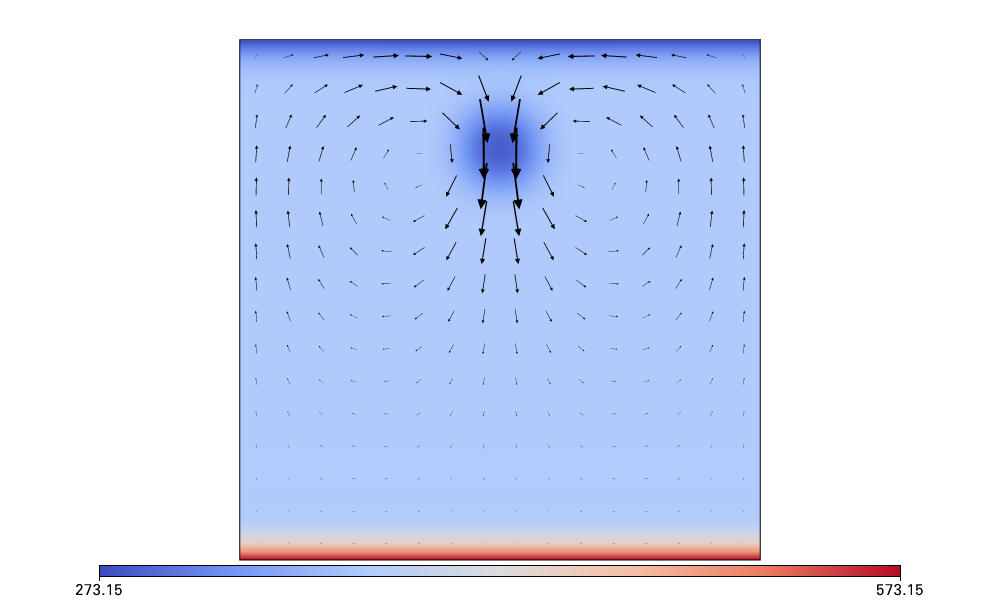

In [24]:
Fig = vis.Figure(figsize=(1000,600))
Fig.Points(ball_contour, size=10.0, colour="k")
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()